<hr style="height:2px;border:none"/>
<img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">

<center>
    <h1> INF495 - Modelamiento Computacional Aplicado </h1>
    <h1> Desafío 2</h1>
    <h3>José Quezada</h3>
    <h3>Jorge Sanhueza</h3>
</center>
<br>
<hr style="height:2px;border:none"/>

In [1]:
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 6.2. Modeling multi-channel noise
A veces la data consiste en mediciones simultaneas de varias señales, o canales, y es importante entender la interacción de los distintos canales.

Asumiendo que una dispositivo de medicion con $n$ canales y cada uno de estos canales tiene un ruido aditivo, se puede aislar el ruido multicanal prendiendo el mismo y tomar muestras sin que haya una señal de interés. Como por ejemplo, una resonacia electromagnética sin un paciente o testear micrófonos sin que nadie haga sonidos.

Definiendo
$$s_j(t) = \text{señal de ruido del canal de j}$$
y 
$$x_j^{(k)} = s_j(t_k)$$
como la medición del canal de ruido j en el instante k.

Se obtiene que un sistema de n canales por cada instante de tiempo k se tiene un vector:
$$x^(k) = [x_1^{(k)},x_2^{(k)},...,x_n^{(k)}]$$

Se procede a modelar datos sintéticos de 5 canales de ruido con distintas distribuciones de probabilidad.

In [4]:
np.random.seed(10)

#number of samples
n = 1000

# hyperparameters
sigma = 0.3
mu = 1.1

# x_axis
xdata = np.arange(n)

# random distributions for each channel
ch1 = np.random.uniform(0, 2*np.pi, n)
ch2 = np.random.exponential(0.5, n)
ch3 = np.random.gamma(3,2,n)
ch4 = sigma * np.random.randn(n) + mu
ch5 = ch3 * ch1

channels = [ch1,ch2,ch3,ch4,ch5]

## Visualización de ruido
Se proceden a graficar las 5 señales en conjunto, sin embargo no es fácil detectar si existe alguna dependencia entre las señales por lo que se necesita hacer una correlación espacial.

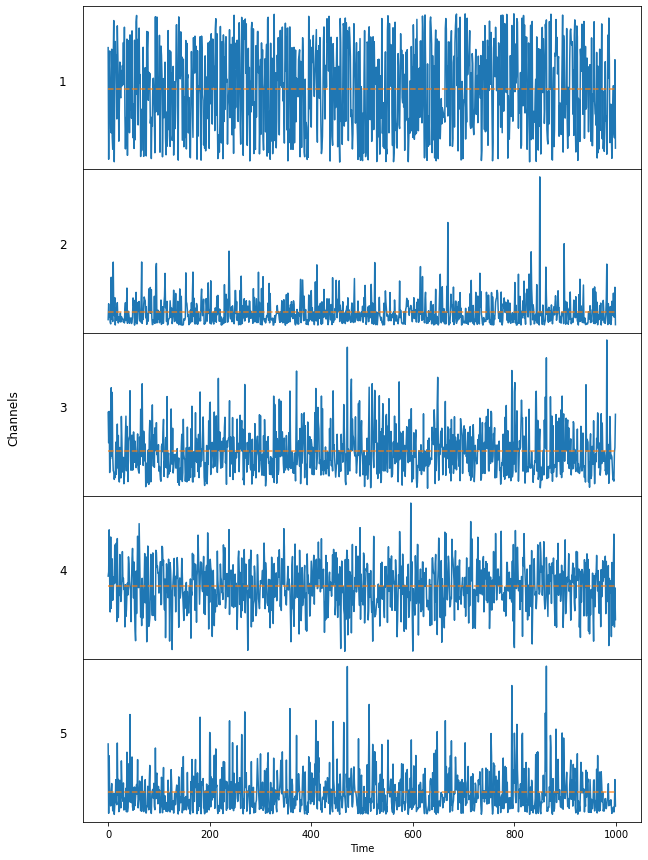

In [5]:
fig, ax = plt.subplots(5, figsize=(10,15))
plt.subplots_adjust(wspace=0,hspace=0)
yprops= dict(rotation='horizontal',labelpad=20,fontsize=12)
for i in range(len(channels)):
    ax[i].plot(xdata,channels[i])
    ax[i].plot(xdata,[np.mean(channels[i])]*n,'--',alpha=0.8,)
    ax[i].set_yticks([])
    ax[i].set_ylabel(f"{i+1}",**yprops)
    if i != len(channels)-1:
        ax[i].set_xticks([])

ax[len(channels)-1].set(xlabel="Time")
fig.supylabel('Channels')
plt.show()

## Matriz de dispersión

Para analizar las dependencias entre señales, se procede a graficar usando una Matriz de dispersión, o "Scatter Matrix", que es, como dice su nombre, una matriz, en cuya diagonal $a_{ii}$ se encuentran los histogramas de cada una de las señales y en las demás posiciones $a_{ij}$ se encuentran graficados los puntos $(s_i^{(k)},s_j^{(k)})$ junto con su índice de correlación $\rho$. Este tipo de gráfico es conveniente para resumir una gran cantidad de mediciones con pocos canales.

En el caso de nuestra data sintética los índices de correlación nos dicen que existe una relación entre los pares de señales (1, 5) y (3, 5), las cuales sabemos que son reales por cómo se generaron los datos. Relación que no es fácil de identificar en el gráfico anterior.

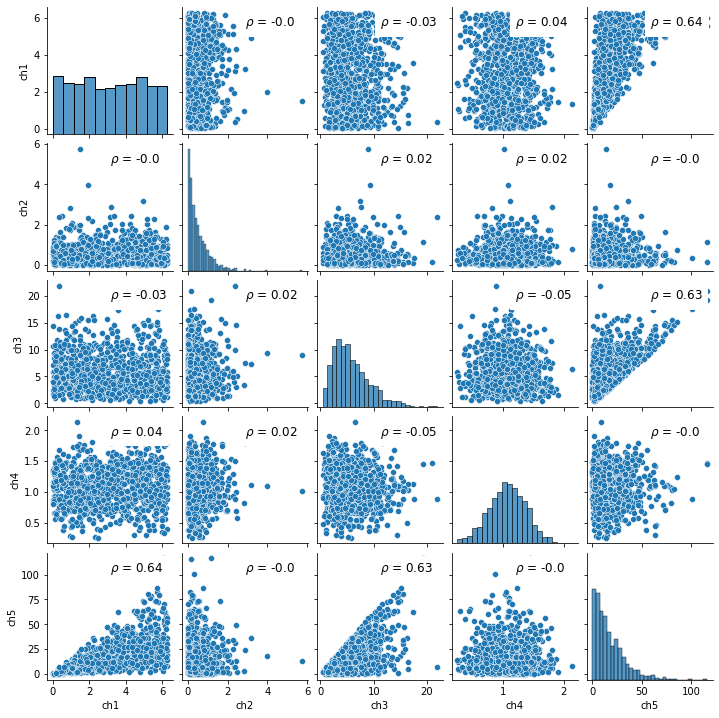

In [6]:
A=np.empty(shape=(n,5))
A[:,0]=ch1
A[:,1]=ch2
A[:,2]=ch3
A[:,3]=ch4
A[:,4]=ch5
df = pd.DataFrame(A,columns=["ch1","ch2","ch3", "ch4", "ch5"])

def corr(x, y, **kwargs):

    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.5, 0.85), backgroundcolor='white', size = 12, xycoords = ax.transAxes)

grid = sb.pairplot(df)
grid.fig.set_size_inches(10,10)
grid = grid.map_upper(corr)
grid = grid.map_lower(corr)

- - -

# 7.1. Neuron firing and biological noise

- Disparos de voltaje en transmisión de información entre neuronas.
- Períodos de baja y alta actividad.
- Se define la probabilidad del tiempo transcurrido hasta que se dispara nuevamente, a partir del firing rate.
- Magnitud aleatoria del disparo.

Para comenzar, se consideran las transmisiones neuronales como eventos ...


Dada una tasa de disparos $\lambda$ y la variable aleatoria

$$N(\tau) = \text{número de disparos en } [t, t + \tau]$$

se tiene su densidad de probabilidad, modelada a partir de una distribución de Poisson

\begin{equation}
P\{N_t(\tau) = n\} = \frac{(\lambda \tau)^n}{n!} e^{−\lambda \tau} = p_n(\lambda \tau)
\end{equation}

Para encontrar una expresión para el tiempo transcurrido entre el último disparo, en t, y uno nuevo en t + $\tau,$ se busca que esta densidad corresponda a:

\begin{align*}
\pi_t(\tau) d\tau &= \text{probabilidad de que el siguiente disparo ocurra en } [t + \tau, t + \tau + d\tau] \\
\pi_t(\tau) d\tau &= P\{\text{siguiente disparo en } [t + \tau, t + \tau + d\tau]\} \\
\pi_t(\tau) d\tau &= P\{\text{ningún disparo en } [t, t + \tau]\} \times P\{\text{al menos un disparo en } [t + \tau, t + \tau + d\tau]\}
\end{align*}

Lo que es equivalente a:

\begin{align*}
\pi_t(\tau) d\tau &= P\{N_t(\tau)\ =\ 0\} \times P\{N_{t+\tau}(d\tau) > 0 \} \\
&= p_0(\lambda \tau) \sum_{j = 1}^\infty p_j(\lambda d\tau) \\
&= p_0(\lambda \tau)\ (1-p_0(\lambda d\tau))
\end{align*}

y, reemplazando con (1), se obtiene:
\begin{equation}
\tag{2}
    \pi_t(\tau)d\tau = e^{−\lambda t}(1 − e^{−\lambda d\tau})
\end{equation}
Luego, utilizando la expansión de series de Taylor,
$$e^{−\lambda d\tau} = 1 - \lambda d\tau + \mathcal{O}((d\tau)^2)$$

Al ser $d\tau$ lo suficientemente pequeño, se omite el término cuadrático en la expresión, la que, al ser reemplazada en (2), resulta:

$$\pi_t(\tau)d\tau = \lambda e^{-\lambda \tau} d\tau$$

Lo que significa que el tiempo de espera corresponde a la distribución exponencial:

$$\pi_t(\tau)= \lambda e^{-\lambda \tau}$$

Para obtener el tiempo buscado $s$, es necesario obtenerla a partir de la probabilidad acumulada hasta $s$.

$$\Phi(s) = \lambda \int_{0}^{s} e^{-\lambda \tau} d\tau = 1-e^{-\lambda s}$$

Finalmente, considerando una variable aleatoria 
$$\xi \sim \text{Uniform}((0,1))$$

Se obtiene una expresión para s al resolver 
$$\xi = \Phi(s) = 1-e^{\lambda s} \Rightarrow s = -\frac{1}{\lambda} \log{(1-\xi)}$$

Mientras que la magnitud de la señal se distribuye de manera uniforme entre 0 y 1.
$$\text{signal} \sim \text{Uniform}((0,1))$$

## Caso 1 
#### Firing rates with constant rate

### Baja actividad  
$\lambda = 0.02$

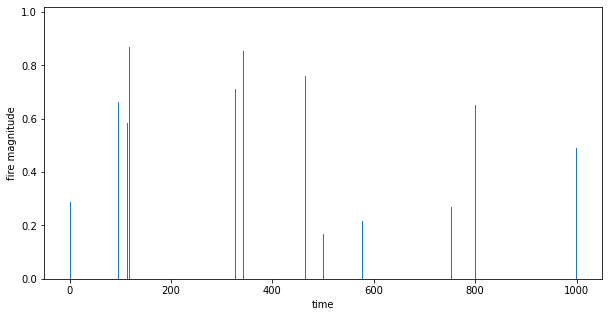

In [14]:
# Baja actividad
np.random.seed(21)
T = 1000
signal = np.zeros(T+1)
lambda_0 = 0.02
t = 0

while t < T:

    # random uniforme entre (0,1)
    xi = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)
    # tiempo hasta siguiente señal
    s = -1 / lambda_0 * np.log(1 - xi)
    # avance de tiempo
    t = min(t + round(s),T)
    # señal random
    signal[t] = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)

plt.figure(figsize=(10,5))
plt.bar(np.arange(T+1),signal)
plt.xlabel("time")
plt.ylabel("fire magnitude")
plt.show()

### Alta actividad  
$\lambda = 1.02$

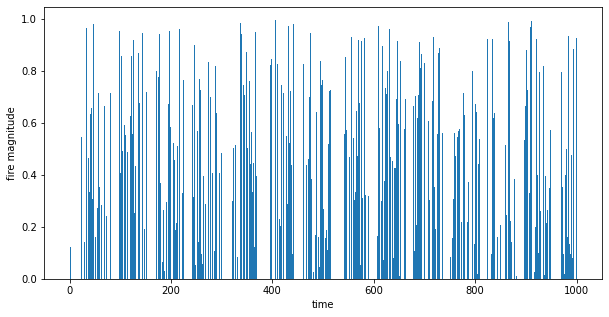

In [13]:
# Alta actividad
np.random.seed(100)
T = 1000
signal = np.zeros(T+1)
lambda_0 = 1.02
t = 0

while t < T:
    
    # random uniforme entre (0,1)
    xi = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)
    # tiempo hasta siguiente señal
    s = -1 / lambda_0 * np.log(1 - xi)
    # avance de tiempo
    t = min(t + round(s),T)
    # señal random
    signal[t] = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)
    
plt.figure(figsize=(10,5))
plt.bar(np.arange(T+1),signal)
plt.xlabel("time")
plt.ylabel("fire magnitude")
plt.show()

## Caso 2
#### Firing rates with low and high activity rates

$$
\lambda_t = 
\begin{cases} 
    0.02 & \text{if low activity}\\
    (0.52, 1.02) & \text{if high activity}
\end{cases}
$$

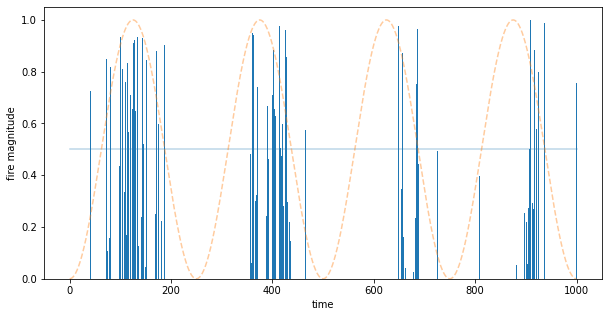

In [12]:
np.random.seed(11)
T = 1000
signal = np.zeros(T+1)
lambda_0 = 0.02
f = 0.002
t = 0

sin_val = lambda t: (np.sin(2*np.pi*f*t))**2
act = lambda t: (lambda_0 + sin_val(t)) if sin_val(t) > 0.5 else lambda_0

while t < T:
    
    #random uniforme entre (0,1)
    xi = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)
    lambda_act = act(t)
    s = -1 / lambda_act * np.log(1 - xi)
    t = min(t + round(s),T)
    signal[t] = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)

time = np.arange(T+1)
plt.figure(figsize=(10,5))
plt.bar(time, signal)
plt.plot(time, 0*time+0.5, alpha=0.3)
plt.plot(time, sin_val(time), '--', alpha=0.4)
plt.xlabel("time")
plt.ylabel("fire magnitude")
plt.show()

## Caso 3
#### Firing rates with low and high activity rates by considering slower time intervals

Para corregir el algoritmo, se parte dividiendo el intervalo $[t, t+\tau]$ en n partes iguales.

$$\Delta\tau = \frac{\tau}{n}$$

identificando cada punto de división como:
$$\tau_j = t + j \Delta \tau, 0 \leq j \leq n$$

De esta forma, la expresión para la probabilidad de un periodo sin disparos ...:

\begin{align*}
P\{\text{ningún disparo en }[t, t+ \tau]\} &= P\{\text{ningún disparo en }[\tau_0, \tau_1]\} \times P\{\text{ningún disparo en }[\tau_1, \tau_2]\} \times \dots \\ & \quad \times P\{\text{ningún disparo en }
[\tau_{n-1}, \tau_n]\} 
\\
& = \mathrm{P}\left\{N_{\tau_{0}}(\Delta \tau)=0\right\} \times \mathrm{P}\left\{N_{\tau_{1}}(\Delta \tau)=0\right\} \times \cdots \\
& \quad \times \mathrm{P}\left\{N_{\tau_{n-1}}(\Delta \tau)=0\right\}

\end{align*}

Entonces, asumiendo que $N_t$ corresponde a una distribución de Poisson y que $\Delta\tau$ es lo suficientemente pequeño para asumir que $\lambda t$ es constante en $\Delta \tau$, este producto se puede aproximar como:

$$
p_{0}\left(\lambda_{\tau_{0}} \Delta \tau\right) p_{0}\left(\lambda_{\tau_{1}} \Delta \tau\right) \cdots p_{0}\left(\lambda_{\tau_{n-1}} \Delta \tau\right)=\exp \left(-\left(\lambda_{\tau_{0}}+\lambda_{\tau_{1}}+\cdots+\lambda_{\tau_{n-1}}\right) \Delta \tau\right)
$$

Obteniendo la siguiente expresión, cuando $\Delta \tau \rightarrow 0$ y $n \rightarrow \infty$

$$\mathrm{P}\{\text {ningún disparo en }[t, t+\tau]\}=\exp \left(-\int_{t}^{t+\tau} \lambda_{\tau^{\prime}} d \tau^{\prime}\right)$$


Tal como en el Caso 1, se tiene:
$$
P\{\text {al menos un disparo en }[t+\tau, t + \tau + d\tau]\} \approx 1-e^{-\lambda_{t + \tau} d\tau} \approx \lambda_{t+\tau} d \tau
$$

Luego,

$$
\begin{aligned}
\pi_{t}(\tau) d \tau &= P\{\text {ningún disparo en }[t, t+\tau]\} \times P\{\text {al menos un disparo en }[t + \tau, t + \tau + d\tau]\} \\
&=\lambda_{t+\tau} \exp \left(-\int_{t}^{t+\tau} \lambda_{\tau^{\prime}} d \tau^{\prime}\right) d \tau
\end{aligned}
$$

Obteniendo la expresión de la distribución de probabilidad acumulada:

$$
\Phi_{t}(s)=\int_{0}^{\tau} \pi_{t}(\tau) d \tau=1-\exp \left(-\int_{t}^{t+s} \lambda_{\tau} d \tau\right)
$$

Para obtener la expresión del tiempo de espera, se considera una distribución uniforme $\xi$ y se resuelve la siguiente ecuación:
$$\Phi(s) = \xi$$

que equivale a:

\begin{equation}
\tag{3}
\int_{t}^{t+s} \lambda_\tau d\tau = -\log(1-\xi) = p
\end{equation}


Para aproximar esta integral, se define $\Delta \tau > 0$ como el tamaño de discretización y $p=-\log (1-$ $\xi) .$ Si

$$
\tau_{n}=t+n \Delta \tau, \quad n=0,1, \ldots
$$

se aproximan las integrales de $\lambda_{\tau}$ en los subintervalos $\Delta \tau$ por la regla del trapezoide.

\begin{equation}
\tag{4}
\int_{\tau_{n}}^{\tau_{n+1}} \lambda_{\tau} d \tau \approx \frac{\Delta \tau}{2}\left(\lambda_{\tau_{n+1}}+\lambda_{\tau_{n}}\right)=\Delta L_{n}
\end{equation}

Para aproximar $s$ según (3), se busca $l$ tal que:

$$
\sum_{n=0}^{\ell-1} \Delta L_{n}<p \leq \sum_{n=0}^{\ell} \Delta L_{n}
$$

Para asegurar que $\tau_{\ell-1} < s \leq \tau_{\ell}$, se usa interpolación lineal para determinar $s$. Considerando $\frac{\Delta L_\ell}{\Delta\tau}$ como pendiente de la interpolación y $(\ell - 1) \Delta\tau$ como $s_0$.

$$
p=\sum_{n=0}^{\ell-1} \Delta L_{n}+\frac{\Delta L_{\ell}}{\Delta \tau}(s-(\ell-1) \Delta \tau)=\sum_{n=0}^{\ell} \Delta L_{n}+\frac{\Delta L_{\ell}}{\Delta \tau}(s-\ell \Delta \tau)
$$

Obteniendo así, la expresión:

$$ s = \left(\ell+\frac{p-\sum_{n=0}^{\ell} \Delta L_{n}}{\Delta L_{\ell}}\right) \Delta \tau $$

Sin embargo, si se escoge un $\Delta\tau$ suficientemente pequeño, se puede redondear s al punto $\tau_j$ más cercano, que satisfaga la ecuación, pudiendo así considerar $\Delta\tau = 1$.

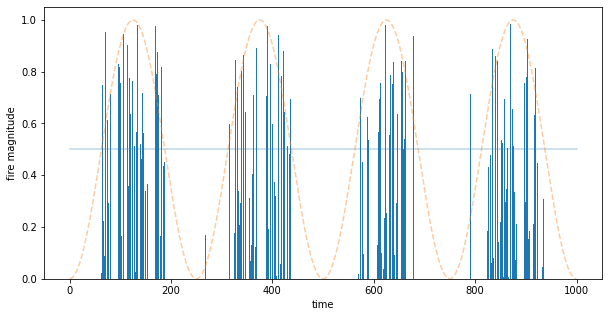

In [11]:
np.random.seed(10)
T = 1000
signal = np.zeros(T+1)
lambda_0 = 0.02  #inicia con baja actividad
f = 0.002
t = 0

sin_val = lambda t: (np.sin(2*np.pi*f*t))**2
act = lambda t: (lambda_0 + sin_val(t)) if sin_val(t) > 0.5 else lambda_0

while t < T:
    
    # random uniforme entre (0,1)
    xi = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)
    # probabilidad de disparo
    p = -np.log(1 - xi)
    # índice que ayuda a determinar el momento del disparo
    L = 0

    lambda_act = act(t)

    while L < p:

        lambda_next = act(t+1)
        dL = 0.5 * (lambda_act + lambda_next)
        L += dL
        lambda_act = lambda_next
        t += 1

    if t <= T:
        signal[t] = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)

time = np.arange(T+1)
plt.figure(figsize=(10,5))
plt.plot(time, 0*time+0.5, alpha=0.3)
plt.bar(time, signal)
plt.xlabel("time")
plt.ylabel("fire magnitude")
plt.plot(time, sin_val(time), '--', alpha=0.4)
plt.show()

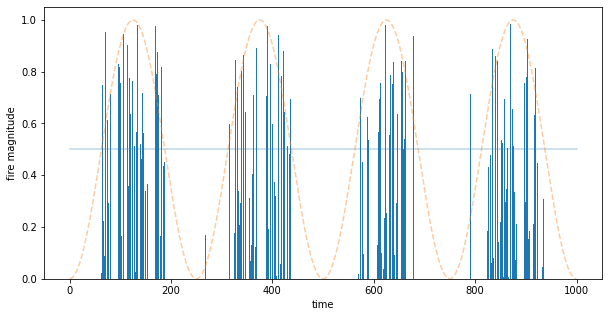

In [55]:
# más parámetros

np.random.seed(10)
T = 1000
signal = np.zeros(T+1)
lambda_0 = 0.02  #inicia con baja actividad
f = 0.002

d_tau = 1  # discretization step

sin_val = lambda t: (np.sin(2*np.pi*f*t))**2
act = lambda t: (lambda_0 + sin_val(t)) if sin_val(t) > 0.5 else lambda_0
t = 0
while t < T:

    l = 0  # steps hasta siguiente disparo
    s = 0  # tiempo entre último y siguiente disparo
    
    # random uniforme entre (0,1)
    xi = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)
    # probabilidad de disparo
    p = -np.log(1 - xi)
    # variable equivalente a integral (4)
    L = 0

    lambda_act = act(t)

    while L < p:

        l += 1
        lambda_next = act(t + l * d_tau)
        dL = 0.5 * (lambda_act + lambda_next) * d_tau
        # if 200 < t < 310:
        #     print("dL:", dL)
        L += dL
        lambda_act = lambda_next

    s = (l + (p - L) / dL) * d_tau
    t = int(t + np.ceil(s))

    if t <= T:
        # print(t)
        # print("s:", s)
        # print("interpol:", (l + (p - L)/ dL) * d_tau)
        signal[t] = np.random.uniform(low=np.nextafter(0.0, 1.0), high=1)


time = np.arange(T+1)
plt.figure(figsize=(10,5))
plt.plot(time, 0*time+0.5, alpha=0.3)
plt.bar(time, signal)
plt.xlabel("time")
plt.ylabel("fire magnitude")
plt.plot(time, sin_val(time), '--', alpha=0.4)
plt.show()

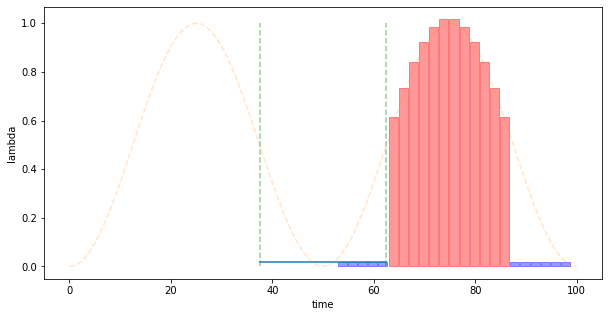

In [82]:
plt.figure(figsize=(10,5))

plt.plot([37.5,62.5], [0.02, 0.02])
plt.plot()
plt.plot([37.5,37.5], [0,1], '--g', alpha=0.4)
plt.plot([62.5,62.5], [0,1], '--g', alpha=0.4)

t = 54
while t < T:
    lambda_act = act(t)
    if lambda_act == 0.02:
        l_color = 'b'
    else:
        l_color = 'r'
    plt.fill_between([t-1.1,t+0.7], 0, lambda_act, color=l_color,  alpha=0.4)

    t += 2

plt.xlabel("time")
plt.ylabel("lambda")
plt.plot(time, sin_val(time), '--', alpha=0.2)
plt.show()